# Báo cáo bài tập lớn môn Học máy
**Giảng viên**  : Trần Quốc Long  
**Mã học phần** : INT3405E_20  
**Sinh viên**   : Lê Kim Long  
**Mã sinh viên**:18020852  

# 1.Mô tả bài toán
Quora Insincere Question Classification là một bài toán của Quora đặt ra, sử dụng sự trợ giúp từ cộng đồng, giúp họ phân loại những câu hỏi không chân thành.

Nhiệm vụ của bài toán là sử dụng tập dữ liệu mà Quora cung cấp để phân loại đâu là những câu hỏi mang hàm ý không chân thành, mang nội dung xấu độc, gây hiểu lầm.

In [ ]:
# Load libraries
import re
import sys
import math
import string
import zipfile
import unicodedata
import nltk

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter
from gensim.models import KeyedVectors
from wordcloud import WordCloud, STOPWORDS
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from keras import backend as K
from keras.models import Sequential, Model
from keras import initializers, regularizers, constraints
from keras.layers import LSTM, Dense, Bidirectional, Input, Dropout

# 2.Dữ liệu và phân tích dữ liệu

Bộ dữ liệu của Quora cũng cấp bao gồm:
+ Train.csv : tập dữ liệu cho training 
+ Test.csv  : tập dữ liệu để test 
+ embedings : Tập embeding sẵn của một số thư viện

In [ ]:
train_data = pd.read_csv("../input/quora-insincere-questions-classification/train.csv")
test_data = pd.read_csv("../input/quora-insincere-questions-classification/test.csv")

In [ ]:
print("số câu hỏi trong tập train:" , train_data.shape[0])
print("số câu hỏi trong tập test:", test_data.shape[0])
train_data.head()

Dữ liệu train bao gồm 1306122 câu hỏi, dữ liệu test bao gồm 375806 câu hỏi
Các trường dữ liệu được cung cấp:
+ qid : mã id của câu hỏi
+ question_text: câu hỏi 
+ target : nhãn gán sẵn của dữ liệu

In [ ]:
plt.figure(figsize=(10, 5))

# Our original training image
plt.subplot(121)
val = train_data.target.value_counts().values
names = ['Sincere', 'Insincere']
plt.bar(names, val)

# Our original combined mask
plt.subplot(122)
sizes = [train_data[train_data["target"] == 0].shape[0] / train_data.shape[0],train_data[train_data["target"] == 1].shape[0] / train_data.shape[0] ]
plt.pie(sizes, labels = names , autopct='%1.1f%%', shadow=True, startangle=140)
plt.show()

**Nhận xét** : Bộ dữ liệu phân bố không đều có đến 93.8% là câu hỏi có nhãn là 0 mà chỉ có 6.2% có nhãn là 1 cho thấy bộ dữ liệu này bộ dữ liệu mất cân bằng. Từ đó chúng ta có thể thấy được độ đo có thể dùng ở bài toán này là F1 score, vì nó thích hợp cho các trường hợp dữ liệu mất cân bằng này

F1 score là à harmonic mean của precision và recal
$$F1 = \frac{2}{precision^-1 + recall^-1 }$$
Trong đó:
+ Precision trả lời cho câu hỏi trong các trường hợp được dự báo là positive thì có bao nhiêu trường hợp là đúng 
$$Precision = \frac{TP}{TP+FP}$$
+Recall đo lường tỷ lệ dự báo chính xác các trường hợp positive trên toàn bộ các mẫu thuộc nhóm positive
$$Recall = \frac{TP}{TP+FN}$$


## Word Clound
Word Clound là một cách trực quan hoá dữ liệu đưa lại cho chúng ta một cách nhìn đơn giản và dễ nhìn về tần suất của các từ xuất hiện trong dữ liệu. Các từ có tần suất cao thì càng được thể hiện to và đậm và ngược lại 

In [ ]:
# tạo từ điển các từ xuất hiện và tần suất của chúng
def get_word_vocabulary(text):
    word_list = text.split()
    word_frequency = Counter(word_list)
    return dict(word_frequency.most_common())

In [ ]:
# Vẽ word Clound
def draw_word_clound(word_frequency, title, figure_size=(10,6)):
    wordcloud.generate_from_frequencies(word_frequency)
    plt.figure(figsize=figure_size)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()

In [ ]:
# Vẽ 2 word clound đối với 2 loại dữ liệu tương đương với 2 nhãn của dữ liệu
insincere_questions = train_data.question_text[train_data['target'] == 1]
insincere_sample = " ".join(insincere_questions)
insincere_word_freq = get_word_vocabulary(insincere_sample)
insincere_word_freq = dict(list(insincere_word_freq.items())[40:])
wordcloud = WordCloud(width= 5000,
    height=3000,
    max_words=200,
    background_color='white')

draw_word_clound(insincere_word_freq, "Most Frequent Words insincere")

In [ ]:
# Vẽ 2 word clound đối với 2 loại dữ liệu tương đương với 2 nhãn của dữ liệu
sincere_questions = train_data.question_text[train_data['target'] == 0]
sincere_sample = " ".join(sincere_questions)
sincere_word_freq = get_word_vocabulary(sincere_sample)
sincere_word_freq = dict(list(sincere_word_freq.items())[40:])
wordcloud = WordCloud(width= 5000,
    height=3000,
    max_words=200,
    background_color='white')

draw_word_clound(sincere_word_freq, "Most Frequent Words sincere")

# 3. Tiền xử lý dữ liệu

Với những bài toán có dữ liệu dạng text thì việc quang trọng trước khi đưa dữ liệu vào model là chuyển text thành vector. Trong dữ liệu được cung cấp có các bộ embeding được cung cấp sẵn. Trong bài này em sử dụng tập embeding GoogleNew để vector hoá dữ liệu

In [ ]:
# Giải nén và load embeddings
archive = zipfile.ZipFile('/kaggle/input/quora-insincere-questions-classification/embeddings.zip', 'r')
path=archive.open('GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin', 'r')

embeddings_index = KeyedVectors.load_word2vec_format(path, binary=True)

Sau khi load được bộ dữ liệu chúng ta có thể kiểm tra trước độ phủ của bộ dữ liệu(out of vocab)

In [ ]:
# hàm tách từ từ câu trong dữ liệu
def to_vocab(lines):
    vocab = Counter()
    for line in tqdm(lines, position=0):
        vocab.update(line.split())
    return vocab


In [ ]:
# Hàm check độ phủ của bộ embedding
def check_coverage(vocab, embeddings_index):
    embeddings_in_vocab = 0
    embeddings_in_all_text = 0
    oov_in_all_text = 0
    oov = Counter()
    
    for word in tqdm(vocab, position=0):
        if word in embeddings_index:
            embeddings_in_vocab += 1
            embeddings_in_all_text += vocab[word]    
        else:
            oov[word] = vocab[word]
            oov_in_all_text += vocab[word]

    print('Found embeddings for {:.2%} of vocab'.format(embeddings_in_vocab / len(vocab)))
    print('Found embeddings for {:.2%} of all text'.format(embeddings_in_all_text / (embeddings_in_all_text + oov_in_all_text)))
    
    return oov

In [ ]:
vocab = to_vocab(train_data['question_text'])
vocab.most_common(20)

In [ ]:
oov = check_coverage(vocab, embeddings_index)

**Nhận xét**: Độ phủ của tập embedding đối với tập dữ liệu khá thấp nên chúng ta cần tiến hành một số bước xử lý dữ liệu như sau:
 + Xoá các dấu câu và ký tự đặc biệt
 + Xoá các stop word
 + Xoá các số 
 + Đưa một số từ viết tắt về dạng gốc
 + Chuẩn hoá lại một số từ ngữ pháp mới
 + Streaming và Lemmatization mốt số từ ở dạng 's' "ed" về dạng gốc của từ

**Xoá dấu câu và một số ký tự đặc biệt** : Sử dụng 2 từ điển string và unicodedata để xây dựng bộ từ điển dấu câu và sau đó kiểm tra với từng câu trong dữ liệu xem chúng có xuất hiện hay không. Nếu có thì giữ lại còn không thì loại bỏ khỏi câu

In [ ]:
# Build the list of punctuations
punctuation = [chr(i) for i in range(sys.maxunicode) if unicodedata.category(chr(i)).startswith('P')]
for punct in string.punctuation:
    if punct not in punctuation:
        punctuation.append(punct)
punctuation_in_embeddings = [punct for punct in punctuation if punct in embeddings_index]
punctuation_not_in_embeddings = [punct for punct in punctuation if punct not in embeddings_index]
def clean_punct(x):
    for punct in punctuation_not_in_embeddings:
        x = x.replace(punct, ' ')
    for punct in punctuation_in_embeddings:
        x = x.replace(punct, f' {punct} ')
    return x

**Xoá bỏ số**

In [ ]:
def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0–9]{5,}', '#####', x)
        x = re.sub('[0–9]{4}', '####', x)
        x = re.sub('[0–9]{3}', '###', x)
        x = re.sub('[0–9]{2}', '##', x)
    return x

**Xử lý mốt số từ viết tắt về đúng dạng của nó** : chúng ta kiểm tra một số từ có cú pháp viết tắt có trong bộ dữ liệu không, nếu không có thì thay bằng từ viết đầy đủ của chúng

In [ ]:
contraction_dict = {"dont": "do not", "aint": "is not", "isnt": "is not", "doesnt": "does not"
, "cant": "cannot", "mustnt": "must not", "ll":"will" , "re": "are" ,"ll": "will", "wont": "will not" ,"hasnt": "has not"
, "havent": "have not", "arent": "are not", "ain't": "is not", "aren't": "are not"
,"can't": "cannot", "‘cause": "because", "could've": "could have"
, "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not"
, "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would"
,"he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you"
, "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have"
, "I'll": "I will", "I'll've": "I will have","I'm": "I am", "Iam": "I am", "I've": "I have"
, "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have"
,"i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have"
, "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us"
, "ma'am": "madam", "mayn't": "may not", "might've": "might have"
,"mightn't": "might not","mightn't've": "might not have", "must've": "must have"
, "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not"
, "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not"
, "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not"
, "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have"
, "she'll": "she will", "she'll've": "she will have", "she's": "she is"
, "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have"
, "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", 
"that'd've": "that would have", "that's": "that is", "there'd": "there would", 
"there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would"
, "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
"they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
"we'd": "we would", "we'd've": "we would have", "we'll": "we will", 
"we'll've": "we will have", "we're": "we are", "we've": "we have", 
"weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
"what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
"when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", 
"who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
"why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
"would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", 
"y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are",
"y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", 
"you'll": "you will", "youll":"you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [ ]:
count_abbreviation_word = 0
count_full_word = 0
for word in contraction_dict:
    if word in embeddings_index:
        count_abbreviation_word += 1
    if contraction_dict[word] in embeddings_index:
        count_full_word += 1
print("Số từ viết tắt có trong tập embeddings_index:"  , count_abbreviation_word)
print("Số từ viết đầy đủ có trong tập embeddings_index:" , count_full_word)

In [ ]:
def replace_contractions(x):
    for word in contraction_dict:
        if word not in embeddings_index:
            x = x.replace(word, f'{contraction_dict[word]}')
        else:
            x = x.replace(word, f'{word}')
    return x

**Sửa một số từ**: Trong bộ dữ liệu có cả Anh-Anh và Anh-Mỹ nên chúng ta cần thống nhất ngữ pháp về một loại

In [ ]:
mispell_dict = {
    'grey': 'gray',
    'litre': 'liter',
    'labour': 'labor',
    'travelling':'traveling',
    'favour': 'favor',
    'colour': 'color',
    'centre': 'center',
    'honours': 'honor',
    'theatre': 'theater',
    'realise': 'realize',
    'defence': 'defense',
    'licence': 'license',
    'analyse': 'analyze',
    'practise': 'practice',
    'behaviour': 'behavior',
    'neighbour': 'neighbor',
    'recognise': 'recognize',
    'organisation':'organization',  
    'Qoura': 'Quora',
    'quora': 'Quora',
    'Quorans': 'Quoran',
    'infty': 'infinity',
    'judgement': 'judge',   
    'isnt': 'is not',
    'didnt': 'did not',
    'Whatis': 'what is',
    'doesnt': 'does not',  
    'learnt': 'learn',
    'modelling': 'model',
    'cancelled': 'cancel',
    'travelled': 'travell',
    'travelling': 'travel',
    'aluminium': 'alumini',
    'counselling':'counseling',
    '₹': 'rupee',
    'Brexit': 'Britain exit',
    'Paytm': 'Pay Through Mobile',
    'KVPY': 'Kishore Vaigyanik Protsahan Yojana',
    'GDPR': 'General Data Protection Regulation',
    'INTJ': 'Introversion Intuition Thinking Judgment',   
    'cheque': 'bill',
    'upvote': 'agree',
    'upvotes': 'agree',
    'vape': 'cigarette',
    'jewellery': 'jewell',
    'Fiverr': 'freelance',
    'programd': 'program',
    'programme': 'program',
    'programr': 'programer',
    'programrs': 'programer',
    'WeChat': 'socialmedia',
    'Snapchat': 'socialmedia',
    'Redmi': 'cellphone',
    'Xiaomi': 'cellphone',
    'OnePlus': 'cellphone',
    'cryptos': 'crypto',
    'bitcoin': 'crypto',
    'Coinbase': 'crypto',
    'bitcoins': 'crypto',
    'ethereum': 'crypto',
    'Ethereum': 'crypto',
    'Blockchain': 'crypto',
    'blockchain': 'crypto',
    'cryptocurrency': 'crypto',
    'cryptocurrencies': 'crypto',
}
## Chuẩn hoá ngữ pháp và từ mới
def replace_typical_misspell(sen):
    for word in mispell_dict.keys():
        sen = sen.replace(word, mispell_dict[word])
    return sen

**Xoá bỏ các từ stop word**:

In [ ]:

stopword_list = nltk.corpus.stopwords.words('english')
def remove_stopwords(text, is_lower_case=True):
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

**Stemming vs. lemmatization**
+ Stemming là kỹ thuật dùng để biến đổi 1 từ về dạng gốc (được gọi là stem hoặc root form) bằng cách cực kỳ đơn giản là loại bỏ 1 số ký tự nằm ở cuối từ mà nó nghĩ rằng là biến thể của từ. Ví dụ như chúng ta thấy các từ như walked, walking, walks chỉ khác nhau là ở những ký tự cuối cùng, bằng cách bỏ đi các hậu tố -ed, -ing hoặc -s, chúng ta sẽ được từ nguyên gốc là walk. Người ta gọi các bộ xử lý stemming là Stemmer.
+ Khác với Stemming là xử lý bằng cách loại bỏ các ký tự cuối từ một cách rất heuristic, Lemmatization sẽ xử lý thông minh hơn bằng một bộ từ điển hoặc một bộ ontology nào đó. Điều này sẽ đảm bảo rằng các từ như “goes“, “went” và “go” sẽ chắc chắn có kết quả trả về là như nhau. Kể các từ danh từ như mouse, mice cũng đều được đưa về cùng một dạng như nhau. Người ta gọi bộ xử lý lemmatization là lemmatizer


In [ ]:
from nltk.stem import SnowballStemmer
from nltk.tokenize.toktok import ToktokTokenizer
def stem_text(text):
    tokenizer = ToktokTokenizer()
    stemmer = SnowballStemmer('english')
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer
wordnet_lemmatizer = WordNetLemmatizer()
def lemma_text(text):
    tokenizer = ToktokTokenizer()
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    tokens = [wordnet_lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

**Hàm tổng hơp** : Tổng hợp các hàm xử lý

In [ ]:
def clean_sentence(x):
    x = x.lower()
    x = clean_punct(x)
    x = clean_numbers(x)
    x = replace_typical_misspell(x)
    x = remove_stopwords(x)
    x = replace_contractions(x)
    x = stem_text(x)
    x = lemma_text(x)
    x = x.replace("'","")
    return x

In [ ]:
# Áp dụng các bước trên vào dữ liệu
from tqdm.notebook import tqdm
tqdm.pandas()

train_data['question_text_cleaned'] = train_data['question_text'].progress_apply(lambda x: clean_sentence(x))
test_data['question_text_cleaned'] = test_data['question_text'].progress_apply(lambda x: clean_sentence(x))

In [ ]:
train_dataframe, val_dataframe = train_test_split(train_data, test_size = 0.1, stratify = train_data['target'], random_state = 42)

# 4.Vector hoá dữ liệu

Sau khi xử lý xong dữ liệu thì ta cần chuyển chúng thành vector bằng tập embeding

In [ ]:
SEQ_LEN = 30
EMB_SIZE = 300

def text_to_array(sen):
    empyt_emb = np.zeros(EMB_SIZE)
    sen = sen[:-1].split()[:SEQ_LEN]
    embeds = [embeddings_index[x] for x in sen if x in embeddings_index]
    embeds+= [empyt_emb] * (SEQ_LEN - len(embeds))
    return np.array(embeds)

# 5.Huấn luyện Mô hình

Với những bài toán thuộc dạng Sequence Classification, ta có thể sử dụng thuật toán mạng Long Short-tẻm memory (LSTM) để xử lý
 Mô hình bao gồm :
 + Layer LSTM với 128 units, cho phép thông tin từ input trước được sử dụng trong tương lai.
 + Bởi vì đây là bài toán binary classification nên ta sẽ thêm output layer với 1 unit và 1 sigmoid activation function.
Compile model với loss function binary_crossentropy và thuật toán Adam optimization.

Một khi model đã được compile, nó có thể được fit.

Một trong những điểm yếu lớn nhất của mô hình LSTM là giới hạn của bộ nhớ, nên chúng ta cần tạo data batch generate.

In [ ]:

batch_size = 128
def batch_gen(train_df):
    n_batches = math.ceil(len(train_df) / batch_size)
    while True: 
        train_df = train_df.sample(frac=1.) 
        for i in range(n_batches):
            texts = train_df.iloc[i * batch_size: (i + 1) * batch_size, 1]
            text_arr = np.array([text_to_array(text) for text in texts])
            yield text_arr, np.array(train_df["target"][i * batch_size:(i + 1) * batch_size])

In [ ]:
val_size = 10000
val_vects = np.array([
    text_to_array(X_text) for X_text in tqdm(
        val_dataframe["question_text"][:val_size],
        position=0
    )
], dtype=float)
val_y = np.array(val_dataframe["target"][:val_size], dtype='int32')

train_data = batch_gen(train_dataframe)
validation_data=(val_vects, val_y)

In [ ]:
model = Sequential()

# Add a long short-term memory layer with 128 units
model.add(LSTM(units=128))

# Add fully connected layer with a sigmoid activation function
model.add(Dense(1, activation="sigmoid"))

# Compile neural network
model.compile(loss='binary_crossentropy', # Cross-entropy
              optimizer='adam', # Adam optimization
              metrics=['accuracy']) # Accuracy performance metric


In [ ]:
# Train neural network
history = model.fit(train_data,
                    epochs=20,
                    steps_per_epoch=1000, 
                    validation_data=validation_data,
                    verbose=True)

## 6. Visulize accurancy và loss của mô hình

In [ ]:
# Get training and test loss histories
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)
# Visualize loss history
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training Loss", "Test Loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

# Get training and test accuracy histories
training_accuracy = history.history["accuracy"]
test_accuracy = history.history["val_accuracy"]
plt.plot(epoch_count, training_accuracy, "r--")
plt.plot(epoch_count, test_accuracy, "b-")
# Visualize accuracy history
plt.legend(["Training Accuracy", "Test Accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy Score")
plt.show();

# 6. Dự đoán trong bộ dữ liệu test

In [ ]:
pred_val_y = model.predict(val_vects, verbose=False)

best_thres = 0
best_thres_id = 0

for thres in np.arange(0.1, 0.901, 0.01):
    thres = np.round(thres, 2)
    value = metrics.f1_score(val_y, (pred_val_y>thres).astype(int))
    if value > best_thres:
        best_thres = value
        best_thres_id = thres
        
print("The best F1 score is {0} at threshold {1}".format(best_thres, best_thres_id))

In [ ]:
def batch_gen_for_submit(test_df):
    n_batches = math.ceil(len(test_df) / batch_size)
    for i in range(n_batches):
        texts = test_df.iloc[i * batch_size: (i + 1) * batch_size, 1]
        text_arr = [text_to_array(text) for text in texts]
        yield np.array(text_arr, dtype=float)

In [ ]:
all_preds = []
for x in tqdm(batch_gen_for_submit(test_data)):
    cc = model.predict(x, verbose=False)
    cc = (cc > best_thres_id).astype(int)
    for i in cc:
        all_preds.append(i[0])

In [ ]:
submit_df = pd.DataFrame({"qid": test_data["qid"], "prediction": all_preds})
submit_df.head(5)

In [ ]:
submit_df

In [ ]:
submit_df.to_csv("submission.csv", index=False)

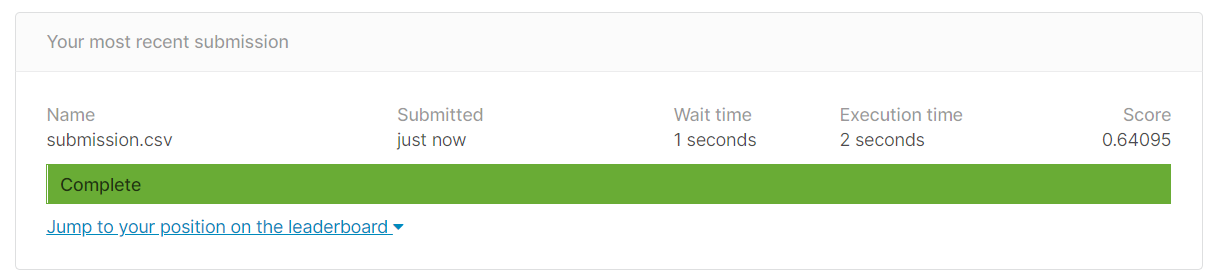